In [1]:
import sys
import os
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
from IPython import display
from IPython.display import clear_output
import pylab as pl
import numpy as np
from scipy.stats import ortho_group
import matplotlib.pyplot as plt
from numba import njit, jit
from time import time
# from helpers import *
from BSMBSS import *
#np.random.seed(13)
import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

In [3]:
N = 100000
NumberofSources = 5
NumberofMixtures = 10
R = np.eye(NumberofSources)
# S = generate_correlated_uniform_sources(R, range_ = [-1,1], n_sources = NumberofSources, size_sources = N) 
S = generate_correlated_copula_sources(rho = 0.6, df = 4, n_sources = NumberofSources, size_sources = N , decreasing_correlation = True)
S = 2 * S -1 
print("The following is the correlation matrix of sources")
display_matrix(np.corrcoef(S))

# Generate Mxr random mixing from i.i.d N(0,1)
A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)

SNR = 30 # dB
NoiseAmp = (10 ** (-SNR/20)) #/ np.sqrt(NumberofSources)
NoisePart = NoiseAmp * np.random.randn(X.shape[0], X.shape[1])
X = X  + NoisePart
SNRinp = 10 * np.log10(np.sum(np.var(X, axis = 1)) / np.sum(np.var(NoisePart, axis = 1)))
print("Input SNR is : {}".format(SNRinp))
print("The following is the mixture matrix A")
display_matrix(A)

The following is the correlation matrix of sources


<IPython.core.display.Math object>

Input SNR is : 33.18884986591887
The following is the mixture matrix A


<IPython.core.display.Math object>

In [4]:
debug_iteration_point = 1000
gamma = np.sqrt(1 - 4e-3)
# gamma = 0.999

# model = OnlineBSM(s_dim = NumberofSources, x_dim = NumberofMixtures, beta = 1e-6, 
#                   gamma = gamma, neural_OUTPUT_COMP_TOL = 1e-7, set_ground_truth = True, S = S, A = A)
model = OnlineBSM(s_dim = NumberofSources, x_dim = NumberofMixtures, beta = 1e-6, 
                  gamma = gamma, whiten_input_ = True,
                  neural_OUTPUT_COMP_TOL = 1e-7, set_ground_truth = True, S = S, A = A)

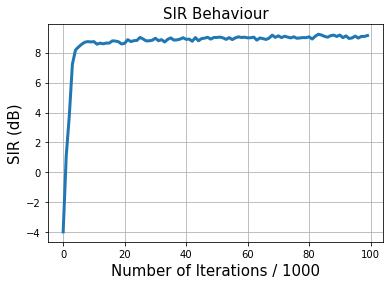

100%|█████████████████████████████████| 100000/100000 [00:18<00:00, 5521.35it/s]


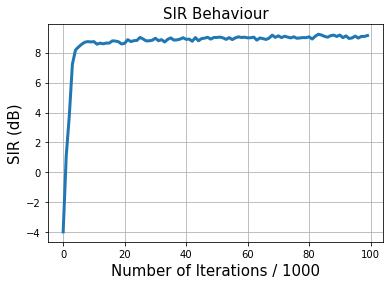

In [5]:
model.fit_batch_antisparse(X = X, n_epochs = 1, neural_dynamic_iterations = 500,
                           neural_lr_start = 0.9, neural_lr_stop = 1e-15, fast_start = True,
                           debug_iteration_point = debug_iteration_point, plot_in_jupyter = True)

In [6]:
Wf = model.compute_overall_mapping(return_mapping = True)
X_white, Wpre = model.whiten_input(X)
Y = Wf @ X_white
Y.shape, X.shape, S.shape

((5, 100000), (10, 100000), (5, 100000))

In [7]:
model.CalculateSIR(Wpre @ A, Wf)

(9.080227856720382, 5)

In [8]:
Y_ = signed_and_permutation_corrected_sources(S.T,Y.T).T

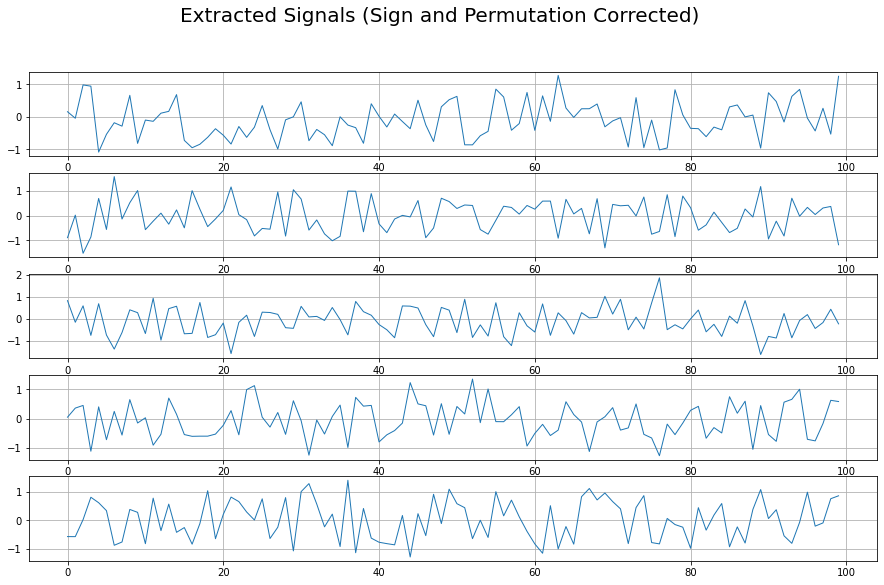

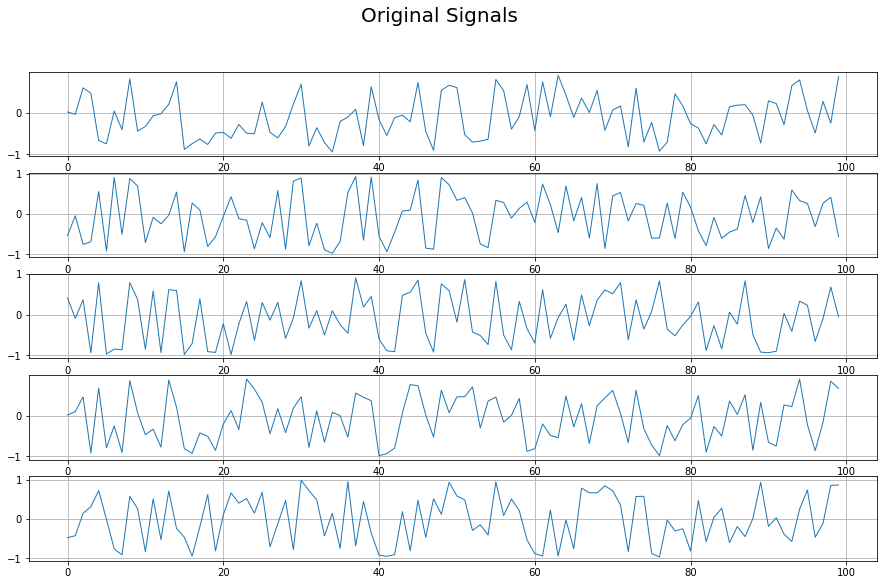

In [9]:
subplot_1D_signals(X = Y_.T[0:100], title = 'Extracted Signals (Sign and Permutation Corrected)' ,figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X = S.T[0:100], title = 'Original Signals' ,figsize = (15.2,9), colorcode = None)